# Importing the packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import set_config
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")
set_config(transform_output='pandas')

# Loading the data

As I mentioned, I will use the `chunksize` parameter of the `read_csv` method of `pandas`.

In [2]:
INTERIM_DATA_PATH = "../data/interim/pickup_coord_data.csv"

df_reader = pd.read_csv(INTERIM_DATA_PATH, chunksize=100000)
df_reader

`df_reader` is not a `DataFrame` object, it is a `TextFileReader` object. We can loop over it to get the chunks. Let us create a random sample.

In [3]:
np.random.seed(2718)  # for reproducibility

all_samples = []

df_reader = pd.read_csv(INTERIM_DATA_PATH, chunksize=100000)

for df in df_reader:
    all_samples.append(df.sample(500))

sample_df = pd.concat(all_samples, axis=0)

In [4]:
sample_df.shape

(166500, 2)

In [5]:
sample_df

,pickup_latitude,pickup_longitude
96887,40.713898,-74.014328
18844,40.644646,-73.781792
92307,40.793365,-73.972595
21583,40.787209,-73.941948
70901,40.760422,-73.989365
...,...,...
33223606,40.760891,-73.976837
33233613,40.728512,-74.004631
33201633,40.737419,-74.005051
33230907,40.748760,-73.937073


So this random sample has 166,500 rows. Now I will plot a scatter using this data on a map.

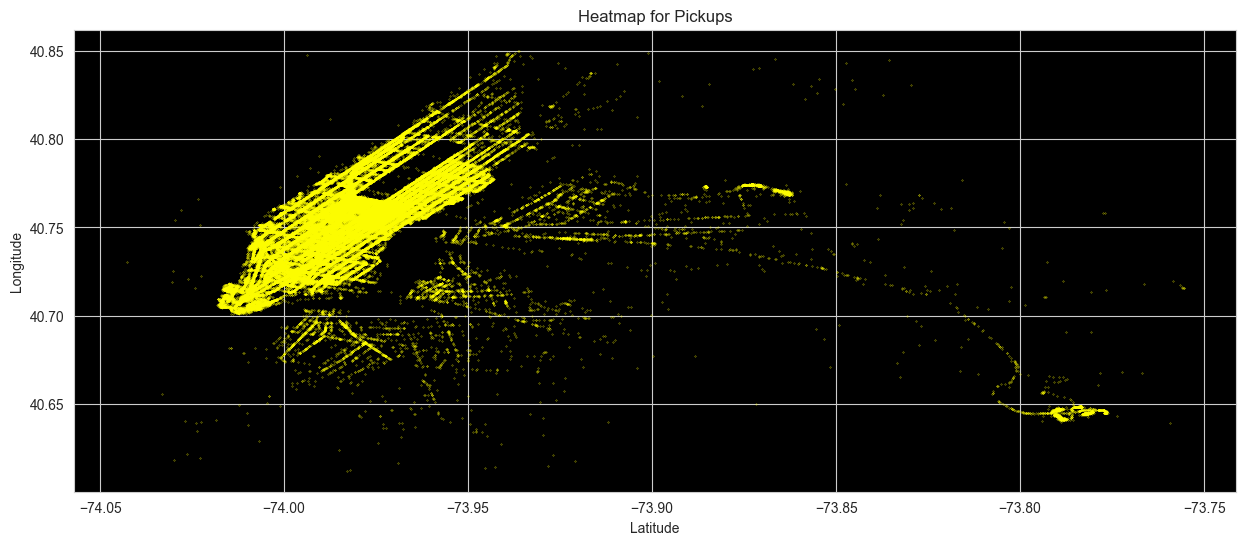

In [6]:
fig,ax = plt.subplots(
    nrows=1, ncols=1, sharey=True, figsize=(15, 6)
)

ax.set_facecolor('k')
ax.scatter(
    sample_df['pickup_longitude'],
    sample_df['pickup_latitude'],
    s=0.05,
    color='yellow'
)
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
plt.grid(True)
plt.show();

# Clustering

Now I will perform mini-batch $k$-means clustering. But for that, I will first standardize the data.

## Standardizing

In [7]:
std_scaler = StandardScaler()
scaled_sample_df = std_scaler.fit_transform(sample_df)
scaled_sample_df

,pickup_latitude,pickup_longitude
96887,-1.361063,-1.092183
18844,-3.893476,5.176003
92307,1.544920,0.032755
21583,1.319773,0.858875
70901,0.340232,-0.419277
...,...,...
33223606,0.357390,-0.081590
33233613,-0.826653,-0.830794
33201633,-0.500930,-0.842105
33230907,-0.086208,0.990289


Let us plot the scatter of this standardized data again.

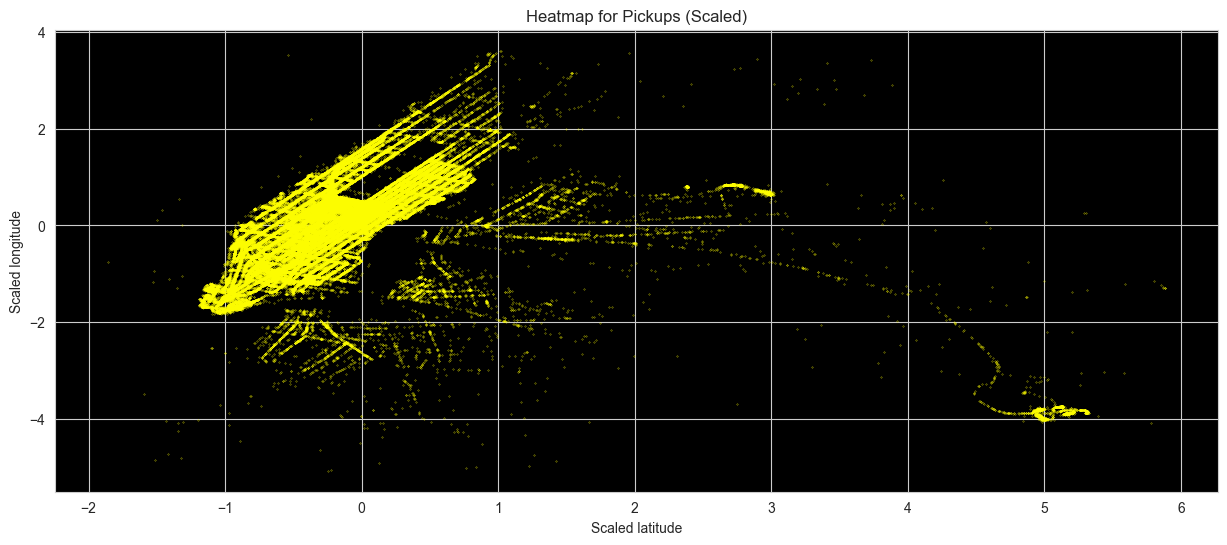

In [8]:
fig,ax = plt.subplots(
    nrows=1, ncols=1, sharey=True, figsize=(15, 6)
)

ax.set_facecolor('k')
ax.scatter(
    scaled_sample_df['pickup_longitude'],
    scaled_sample_df['pickup_latitude'],
    s=0.05,
    color='yellow'
)
ax.set_title('Heatmap for Pickups (Scaled)')
ax.set_xlabel('Scaled latitude')
ax.set_ylabel('Scaled longitude')
plt.grid(True)
plt.show();

## Mini-Batch $k$-Means Clustering

As mentioned in the project document, I will use chunks and `partial_fit` on each of these chunks.

In [9]:
df_reader = pd.read_csv(INTERIM_DATA_PATH, chunksize=100000)

First I will train the `StandardScaler` object using `partial_fit`.

In [10]:
scaler = StandardScaler()

for chunk in df_reader:
    scaler.partial_fit(chunk)

In [11]:
scaler

StandardScaler()

Let us see the mean and standard deviation of both the columns.

In [12]:
print(f"The mean of both columns are: {scaler.mean_}.")
print(f"The stdev of both columns are: {scaler.scale_}.")

The mean of both columns are: [ 40.75107121 -73.9740618 ].
The stdev of both columns are: [0.02722268 0.03675237].


Now, if I directly use the mini-batch $k$-means algorithm, it will calculate distances using the Euclidean distance formula. However, I need to calculate the distances on a globe. Hence, I will define a new function to calculate the Haversine distance.

In [13]:
def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    earth_radius = 3958.8
    distance = earth_radius * c
    return distance

Now I will define a function to calculate the optimum value of $k$, i.e., clusters. This will be the $k$ for which the average distance between the nearest 8 neighbors of all the clusters is about 1-1.5 miles.

In [14]:
def select_optimum_k(k_values: list):
    for k in k_values:
        df_reader = pd.read_csv(INTERIM_DATA_PATH, chunksize=100000)
        mini_batch_k_means = MiniBatchKMeans(n_clusters=k, n_init=20, random_state=42)

        for chunk in df_reader:
            # Scale the chunk
            scaled_chunk = scaler.transform(chunk)
            # Train mini_batch_k_means algorithm
            mini_batch_k_means.partial_fit(scaled_chunk)

        # Get the centroids
        centroids = scaler.inverse_transform(mini_batch_k_means.cluster_centers_)
        
        # Calculate the distances
        all_distances = []  # this is a matrix (which is currently empty)
        for centroid_1 in centroids:
            distances = []
            for centroid_2 in centroids:
                distance = haversine_distance(centroid_1[0], centroid_1[1], centroid_2[0], centroid_2[1])
                distances.append(distance)
            all_distances.append(distances)

        all_distances = np.array(all_distances)

        # Sort the distances
        sorted_distances = np.sort(all_distances, axis=-1)

        # Number of nearby regions
        number_of_nearby_regions = 8

        # Select distances
        selected_distances = sorted_distances[:, 1: number_of_nearby_regions + 1]

        # Average distances
        avg_distances = selected_distances.mean(axis=1)

        # Count averages that fit our criterion
        counter = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).sum()
        percentage = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).mean()
        print(f"For {k} clusters, the number of nearby regions that fits criteria are {counter} and is {percentage * 100:.1f}% regions of total.")

In [15]:
possible_k_values = np.arange(10, 100, 10)
possible_k_values

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [16]:
select_optimum_k(k_values=possible_k_values)

For 10 clusters, the number of nearby regions that fits criteria are 0 and is 0.0% regions of total.
For 20 clusters, the number of nearby regions that fits criteria are 6 and is 30.0% regions of total.
For 30 clusters, the number of nearby regions that fits criteria are 9 and is 30.0% regions of total.
For 40 clusters, the number of nearby regions that fits criteria are 8 and is 20.0% regions of total.
For 50 clusters, the number of nearby regions that fits criteria are 7 and is 14.0% regions of total.
For 60 clusters, the number of nearby regions that fits criteria are 10 and is 16.7% regions of total.
For 70 clusters, the number of nearby regions that fits criteria are 13 and is 18.6% regions of total.
For 80 clusters, the number of nearby regions that fits criteria are 14 and is 17.5% regions of total.
For 90 clusters, the number of nearby regions that fits criteria are 17 and is 18.9% regions of total.


We can see that $k=30$ is working the best. So, let us train this model.

### Model with the selected $k$

In [17]:
df_reader = pd.read_csv(INTERIM_DATA_PATH, chunksize=100000)
mini_batch_k_means = MiniBatchKMeans(n_clusters=30, n_init=20, random_state=42)

for chunk in df_reader:
    # Scale the chunk
    scaled_chunk = scaler.transform(chunk)
    # Train mini_batch_k_means algorithm
    mini_batch_k_means.partial_fit(scaled_chunk)

# Get the centroids
centroids = mini_batch_k_means.cluster_centers_
centroids

array([[ 1.94149572,  0.6614905 ],
       [-0.13980742, -0.07596928],
       [-1.99721801,  1.44528196],
       [-3.83635934,  5.15118517],
       [-1.16343866, -0.81227839],
       [ 0.42137614, -0.13488625],
       [ 0.72209007,  2.8610836 ],
       [-0.52924948, -0.39015448],
       [ 1.07003845,  0.56520318],
       [-2.24451716, -0.3303071 ],
       [-1.00166487, -0.4036074 ],
       [ 1.16185672, -0.10175947],
       [-0.08902033, -0.55920139],
       [ 0.31820801,  1.59046972],
       [-0.04552948, -0.25372558],
       [ 0.20846098, -0.35389222],
       [-1.31780812,  0.52314378],
       [ 2.79102906,  0.81932304],
       [ 0.28712745,  0.12935608],
       [ 0.73099844, -0.27639436],
       [-1.53772972, -1.0082658 ],
       [ 0.67692302,  0.39844824],
       [-0.76412025, -0.74701446],
       [ 1.62394033,  0.1378545 ],
       [-3.07963657, -0.43385234],
       [ 0.3506753 , -0.54018812],
       [-0.57100818, -0.17842182],
       [-0.38830582, -0.76072368],
       [-2.66479788,

These are scaled centroids. We need to inverse transform them to get the coordinates.

In [18]:
centroids = scaler.inverse_transform(mini_batch_k_means.cluster_centers_)
centroids

array([[ 40.80392392, -73.94975046],
       [ 40.74726528, -73.97685385],
       [ 40.69670159, -73.92094427],
       [ 40.64663525, -73.78474354],
       [ 40.7193993 , -74.00391496],
       [ 40.7625422 , -73.97901919],
       [ 40.77072843, -73.8689102 ],
       [ 40.73666362, -73.9884009 ],
       [ 40.78020052, -73.95328925],
       [ 40.68996945, -73.98620137],
       [ 40.72380321, -73.98889533],
       [ 40.78270006, -73.9778017 ],
       [ 40.74864784, -73.99461378],
       [ 40.75973368, -73.91560827],
       [ 40.74983178, -73.98338682],
       [ 40.75674608, -73.98706818],
       [ 40.71519695, -73.95483503],
       [ 40.82705049, -73.94394974],
       [ 40.75888759, -73.96930766],
       [ 40.77097094, -73.98421995],
       [ 40.70921009, -74.01111796],
       [ 40.76949887, -73.95941789],
       [ 40.73026981, -74.00151635],
       [ 40.79527921, -73.96899532],
       [ 40.66723527, -73.9900069 ],
       [ 40.76061753, -73.993915  ],
       [ 40.73552684, -73.98061923],
 

In [19]:
# Perform predictions and assign clusters

sample_predictions = mini_batch_k_means.predict(scaled_sample_df)
sample_predictions

array([20,  3, 23, ..., 27, 29,  7], shape=(166500,), dtype=int32)

In [20]:
np.unique(sample_predictions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)

Let us now plot these clusters.

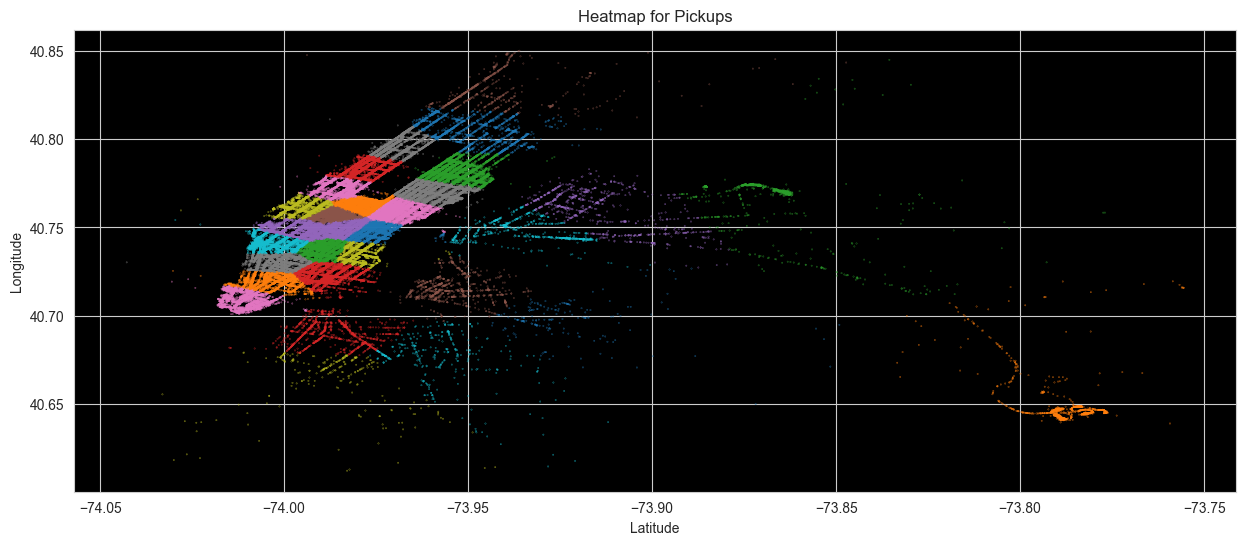

In [21]:
fig,ax = plt.subplots(
    nrows=1, ncols=1, sharey=True, figsize=(15, 6)
)
ax.set_facecolor('k')
ax.scatter(
    sample_df['pickup_longitude'],
    sample_df['pickup_latitude'],
    s=0.05,
    c=sample_predictions,
    cmap="tab10"
)
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
plt.grid(True)
plt.show();

So, we have finally divided NYC map into $k=30$ regions. Now, we will prepare the historical pickup data for all these regions.